UNITED STATES OF AMERICA 
           Year         2         3         4         5         6   7
Year       NaN       NaN       NaN       NaN       NaN       NaN NaN
2     0.923347       NaN       NaN       NaN       NaN       NaN NaN
3     0.932089  0.905793       NaN       NaN       NaN       NaN NaN
4     0.862467  0.978942  0.804306       NaN       NaN       NaN NaN
5     0.830027  0.963505  0.767574  0.985553       NaN       NaN NaN
6     0.853597  0.962254  0.785276  0.982328  0.974548       NaN NaN
7     0.489565  0.480912  0.346830  0.509447  0.508299  0.573414 NaN


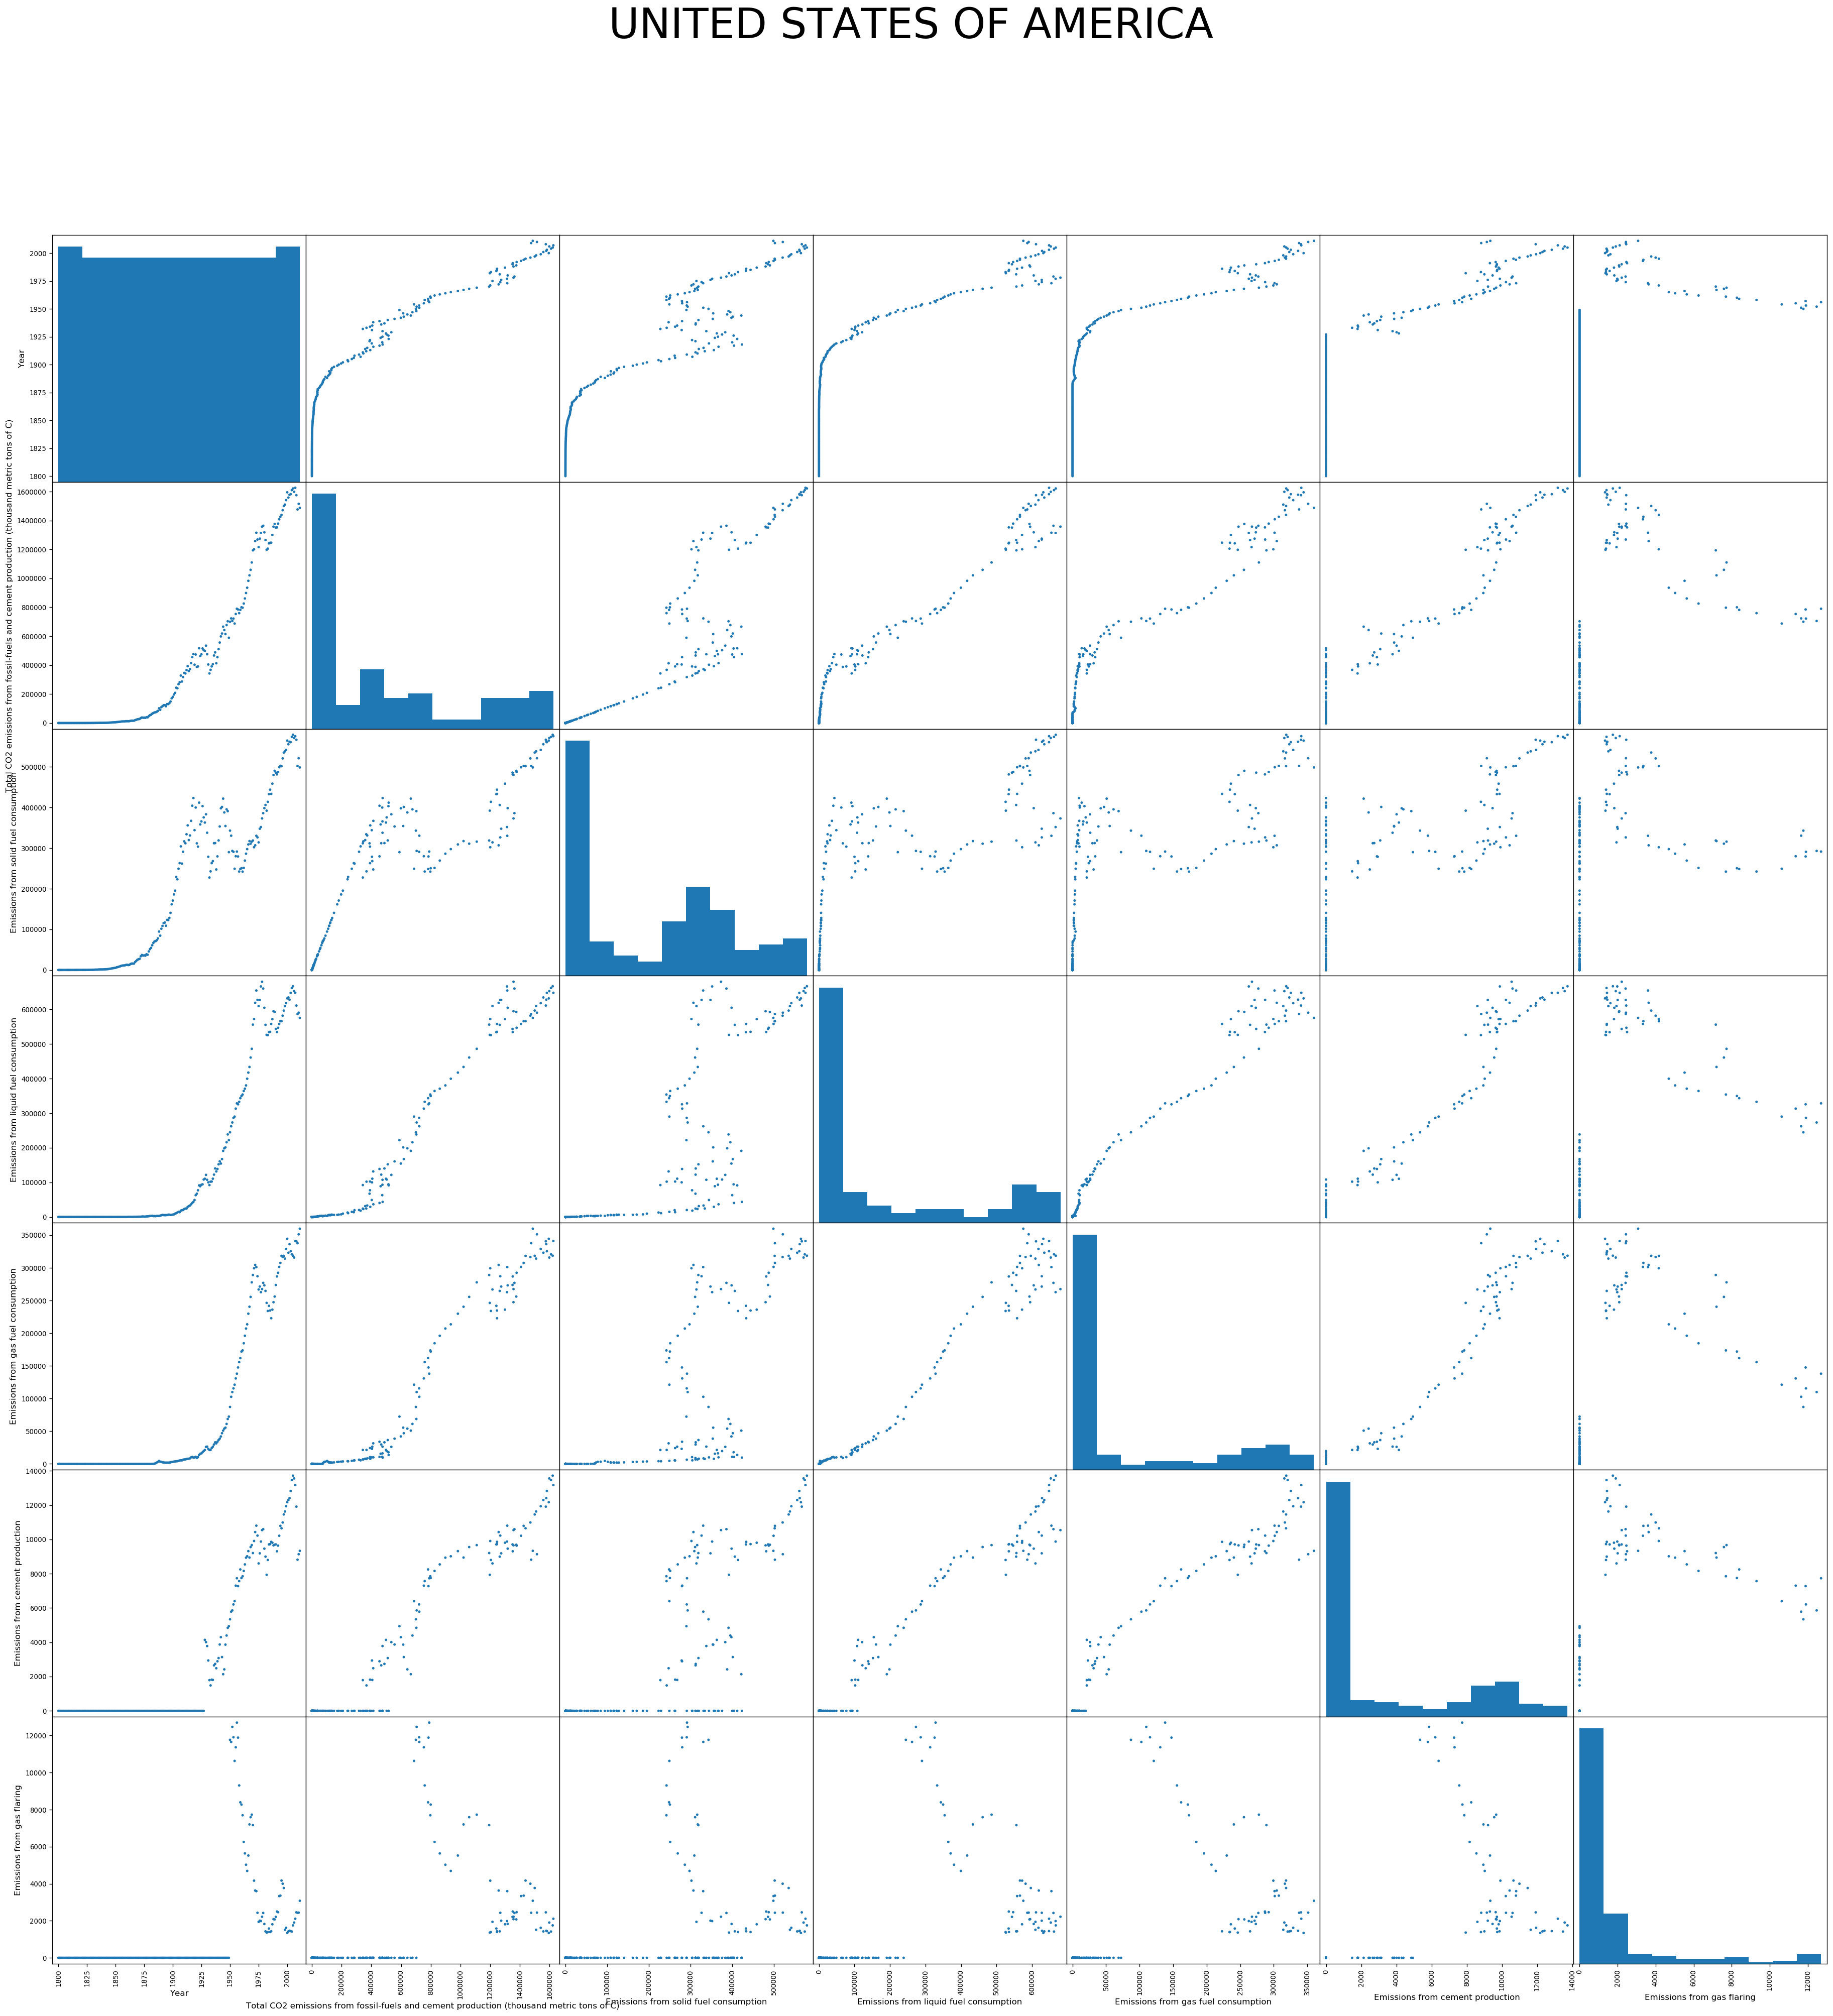

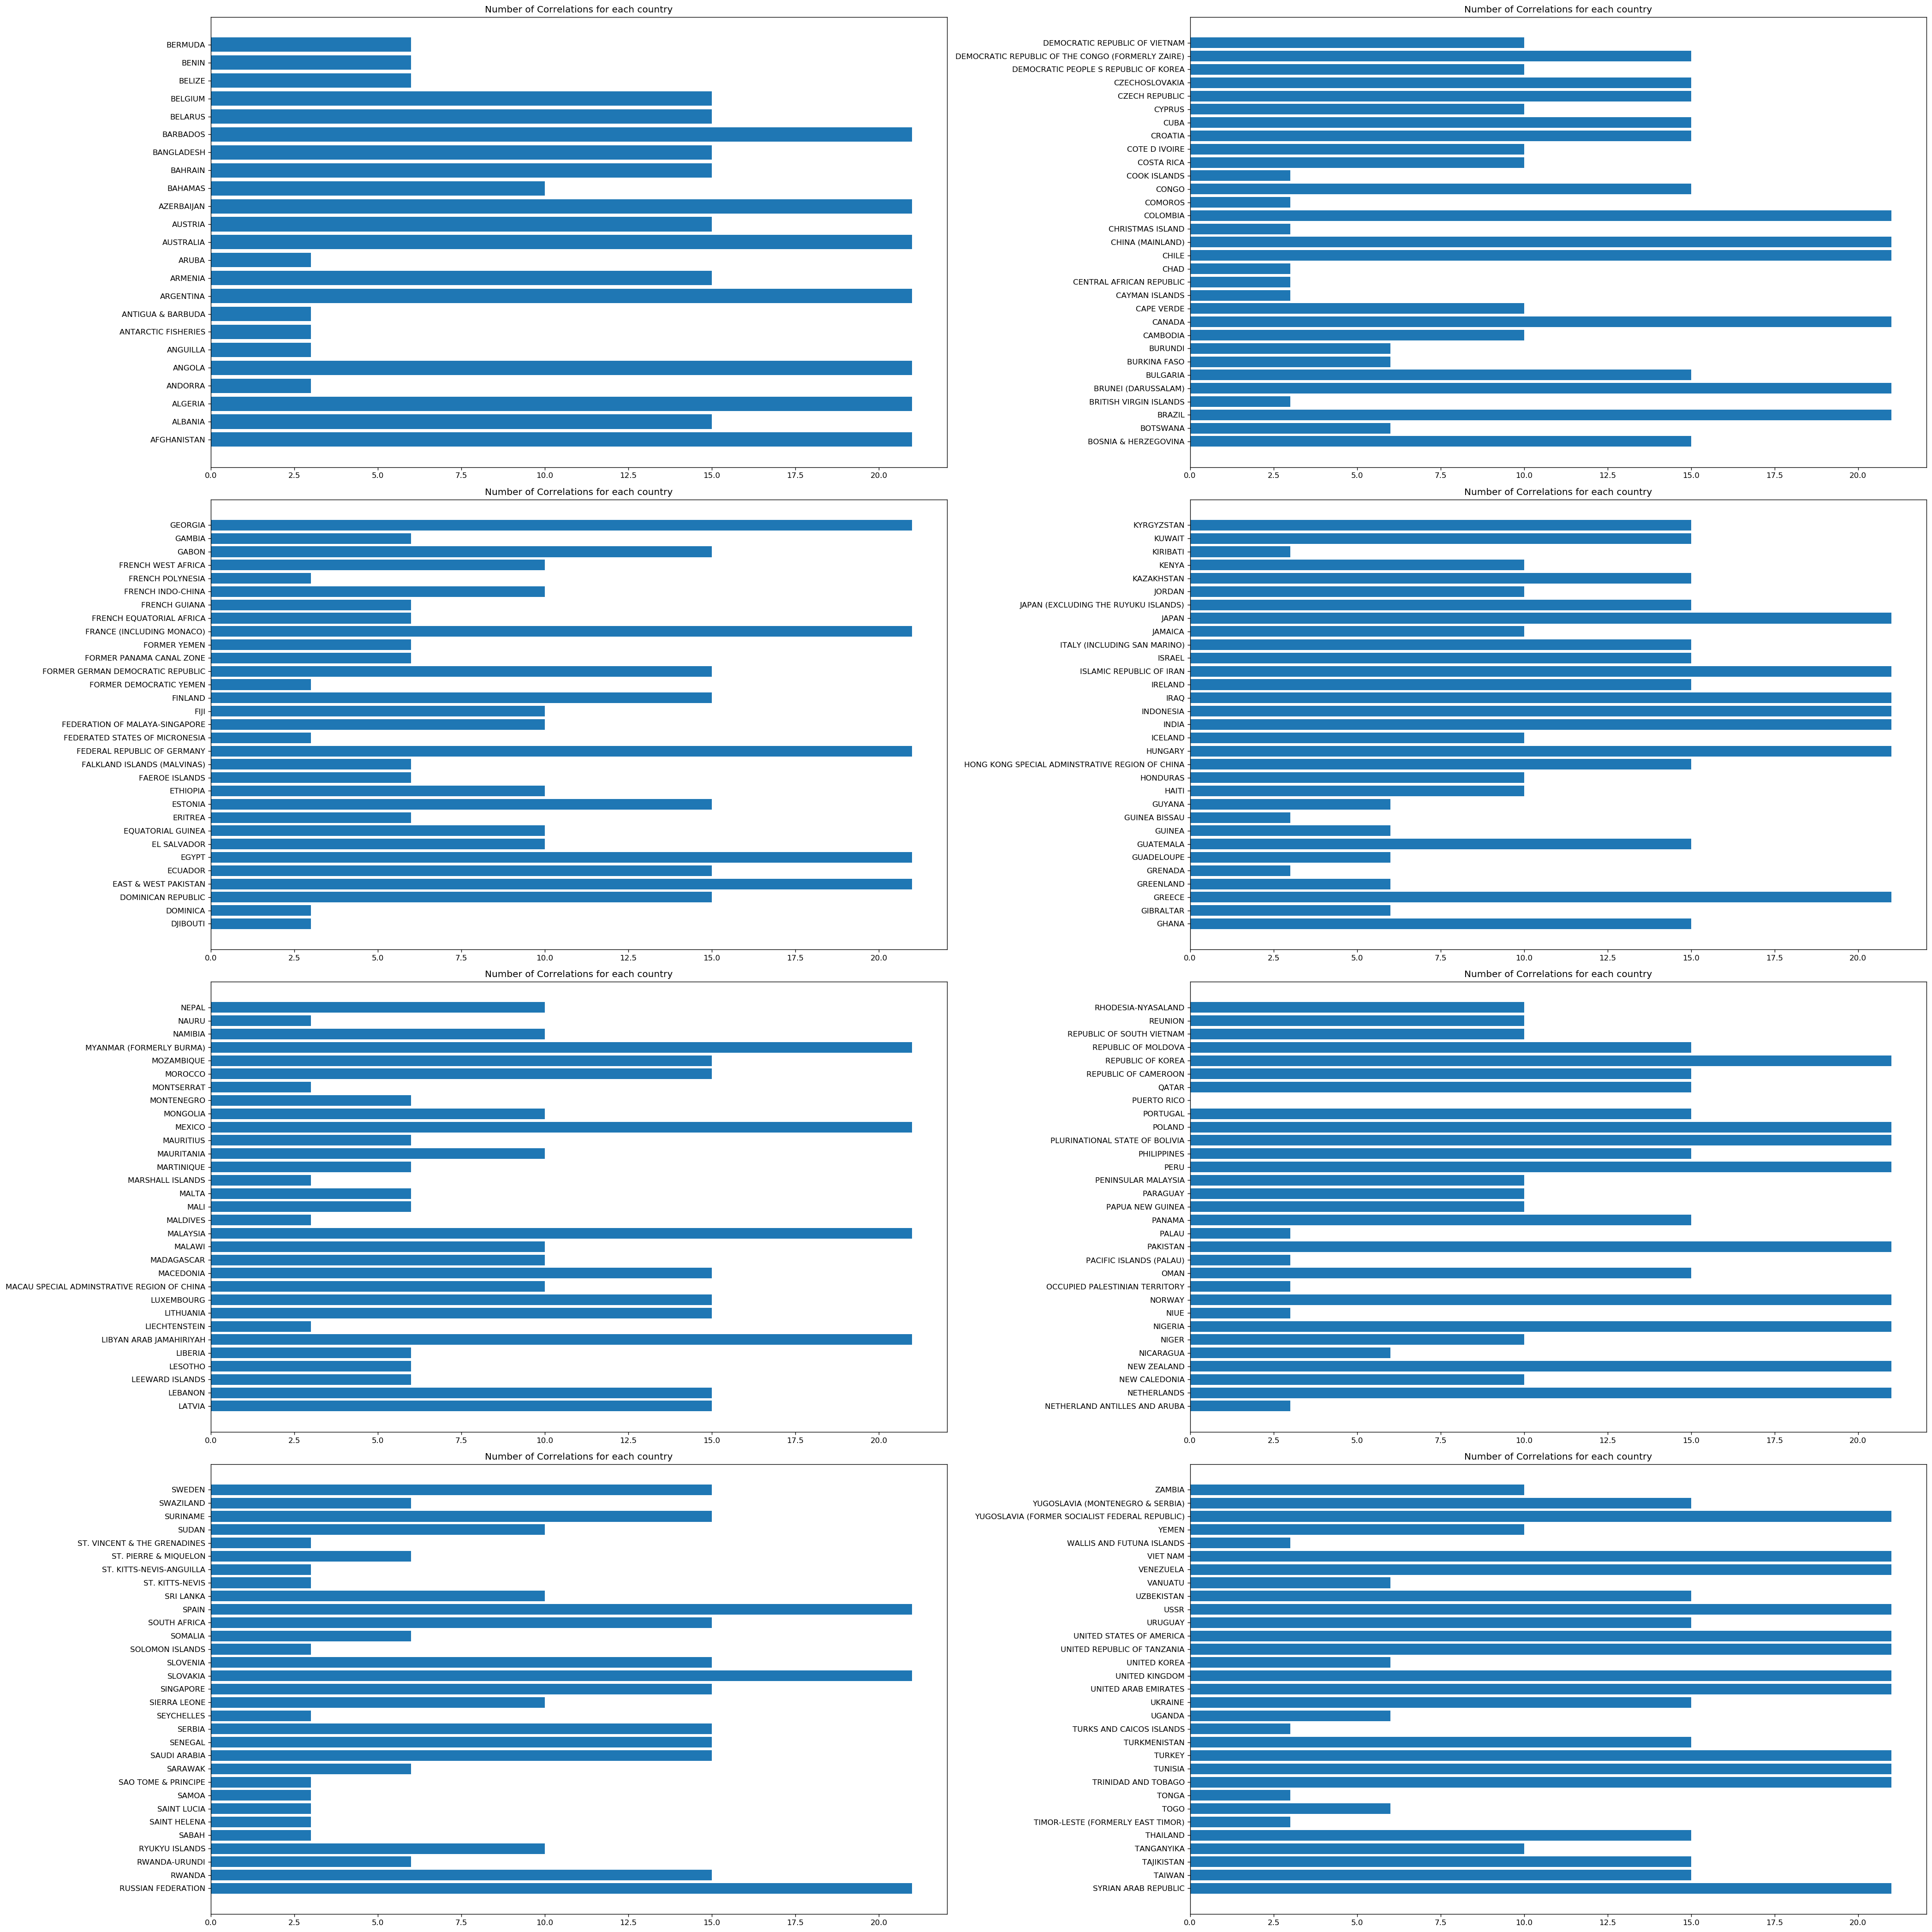

In [58]:
import datetime
import io
import random
from math import log10, sqrt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import pylab as pl
import tabulate
from IPython.display import HTML, Latex, Math, display
from numpy import log
from pandas.plotting import scatter_matrix
from pmdarima.arima.utils import ndiffs
from scipy.optimize import curve_fit
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, adfuller
#from google.colab import files
#For use in colabs data read
#uploaded = files.upload()
#dataset = pd.read_csv(io.BytesIO(uploaded['nation.1751_2011.csv']))
#For use in Spyder data read
dataset = pd.read_csv('nation.1751_2011.csv')
#replace all '.' with 0 in the dataset, drop 'Per capita' column, aggregate values from bunker fuels to total
dataset = dataset.drop('Per capita CO2 emissions (metric tons of carbon)', axis=1)
df = dataset.drop([0, 1], axis=0).replace('.',0)
#all numerical columns transformed to floats
for i in range(1,len(df.columns)):
    df[df.columns[i]] = df[df.columns[i]].astype('float64')
df['Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)'] = df['Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)'] + df['Emissions from bunker fuels (not included in the totals)']
df = df.drop('Emissions from bunker fuels (not included in the totals)', axis=1)
#Kuwait oil fires are aggregated to Kuwait at year 1991
data1= df.loc[8222] + df.loc[8243]
data1[0] = 'KUWAIT'
data1[1] = data1[1] - 1991
df.loc[8222] = data1
df = df.drop(index = 8243)
#grouping by Nation name
grouped = df.groupby(['Nation'])
#storing each dataframe in a dict for easy access to each country's data, df2 is the first cleaning revision
df2 = {}
for name,group in grouped:
    df2[name] = pd.DataFrame(group)
# remove all columns that contain 0 in all rows. update df2, the second cleaning revision
for key,value in df2.items():
    df2[key] = df2[key].loc[:, ~(df2[key] == 0).all()]
#summary of distribution for each country
dfsummary = {}
for key,value in df2.items():
    dfsummary[key] = pd.DataFrame(value).describe(include='all')
#scatter matrix for country with the most correlation (USA)
scatter_matrix(df2.get("UNITED STATES OF AMERICA"), figsize = (38, 38), diagonal = 'hist', alpha=1)
plt.suptitle('UNITED STATES OF AMERICA', size=50)
#Correlation matrix of each country data among all columns. Storing the counts of each correlation for each country
corrcomp = []
corr2 = {}
for key,value in df2.items():
    df3 = df2[key]
    df3 = df3.rename(columns={'Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)':2,'Emissions from solid fuel consumption':3,'Emissions from liquid fuel consumption':4,'Emissions from gas fuel consumption':5,'Emissions from cement production':6, 'Emissions from gas flaring':7,'Per capita CO2 emissions (metric tons of carbon)':8,'Emissions from bunker fuels (not included in the totals)':9})
    corr = df3[df3.columns[1:10]].corr()
    mask = np.tril(np.ones_like(corr, dtype=np.bool), k=-1)
    corr1 = corr.where(mask)
    countrealint = np.count_nonzero(~np.isnan(corr1))
    corrcomp.append({key:countrealint})
    corr2[key] = pd.DataFrame(corr1)
print('UNITED STATES OF AMERICA \n',corr2.get("UNITED STATES OF AMERICA"))
#Creating lists of key,values out of the corrcomp list(dictionary)
all_keys = []
all_vals = []
for k, v in [(k, v) for x in corrcomp for (k, v) in x.items()]:
    all_keys.append(k)
    all_vals.append(v)
#bar graph showing the measures that have correlation
# Create Figure and Subplots
fig, axes = plt.subplots(4,2, figsize=(35,35), dpi=120)
# Plot each axes
axes[0,0].title.set_text('Number of Correlations for each country')
axes[0,0].barh(y=all_keys[0:23], width=all_vals[0:23])
axes[0,1].title.set_text('Number of Correlations for each country')
axes[0,1].barh(y=all_keys[24:55], width=all_vals[24:55])
axes[1,0].title.set_text('Number of Correlations for each country')
axes[1,0].barh(y=all_keys[56:87], width=all_vals[56:87])
axes[1,1].title.set_text('Number of Correlations for each country')
axes[1,1].barh(y=all_keys[88:119], width=all_vals[88:119])
axes[2,0].title.set_text('Number of Correlations for each country')
axes[2,0].barh(y=all_keys[120:151], width=all_vals[120:151])
axes[2,1].title.set_text('Number of Correlations for each country')
axes[2,1].barh(y=all_keys[152:183], width=all_vals[152:183])
axes[3,0].title.set_text('Number of Correlations for each country')
axes[3,0].barh(y=all_keys[184:215], width=all_vals[184:215])
axes[3,1].title.set_text('Number of Correlations for each country')
axes[3,1].barh(y=all_keys[216:247], width=all_vals[216:247])
plt.tight_layout()
plt.show()
#Finding the country's measures that have no correlation
for j in range(0,37): j,[i for i, e in enumerate(all_vals) if e == j]
dropindex = [i for i, e in enumerate(all_vals) if e == 0]
#Aggregated country values 'Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)' per year in a dictionary, then converted to dataframe for easy plotting and use with ML Regression
df5 = {}
groupd = df.groupby(['Year'])
for year,group in groupd:
    df5[year] = pd.DataFrame(group)
for key, value in df5.items():
    df5[key] = value.drop(['Nation','Year','Emissions from solid fuel consumption','Emissions from liquid fuel consumption','Emissions from gas fuel consumption','Emissions from cement production','Emissions from gas flaring'], axis=1)
    df5[key] = sum(df5[key]['Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)'])
df5 =  pd.DataFrame(list(df5.items()), columns=['Year', 'Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)'])
#Prepare data for analysis
x_data = df5["Year"]
y_data = df5["Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)"]

EXPONENTIAL APPROX
Equation


<IPython.core.display.Math object>

Evaluation,Value
Mean absolute error:,0.2503
Mean Squared Error (MSE):,0.0895
Root Mean Squared Error (RMSE):,0.2992
R2-score:,0.9867


Comparison to ground truth,Value
2011dataset (Year = 2011):,9214800.0000
Exponential fit prediction:,15493460.0256
Error %:,68.1367


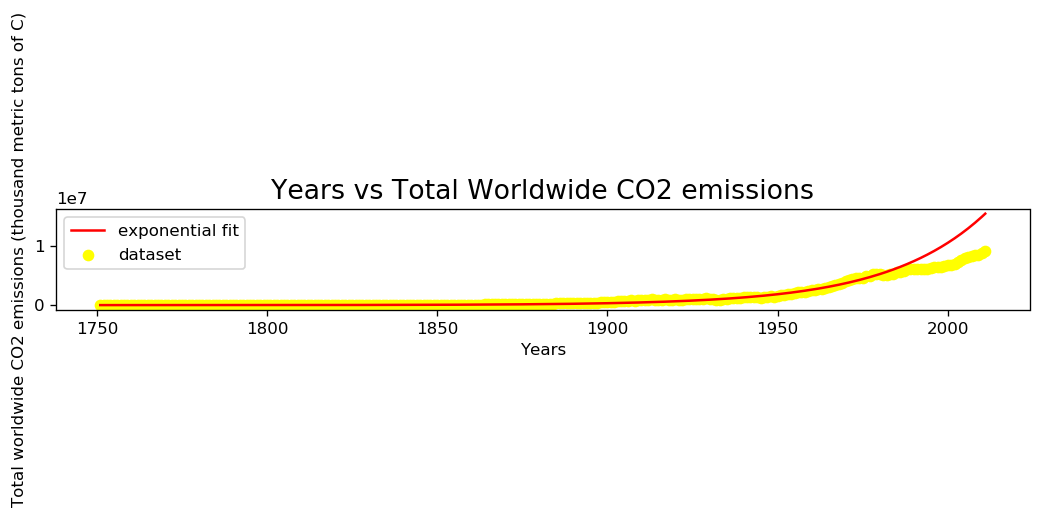

In [59]:
start = "\033[1m"
end = "\033[0;0m"
#Attempting exponential model
xdata = np.array(x_data.values)
ydata = np.log(np.array(y_data.values))
xdata = xdata.reshape(-1,1)
ydata = ydata.reshape(-1,1)
plt.scatter(x_data,y_data, color='yellow', label= 'dataset')
#Create test and train dataset and developing linearization of exponential function for best fit then converting back to exponential
msk = np.random.rand(len(df5)) < 0.8
x_train, y_train = xdata[msk] , ydata[msk]
x_test, y_test = xdata[~msk] , ydata[~msk]
#Obtain coefficients and intercept
regr = linear_model.LinearRegression()
regr.fit (x_train, y_train)
#plt.scatter(x_train, y_train,  color='blue')
#plt.plot(x_train, regr.coef_[0][0]*x_train + regr.intercept_[0], '-r')
#Plot the test dataset
test_y_hat = regr.predict(x_test)
#Plot test data
#plt.scatter(x_test, y_test,  color='blue')
#plt.plot(x_test, regr.coef_[0][0]*x_test + regr.intercept_[0], '-b')
coefficients = [np.exp(regr.coef_[0][0]),np.exp(regr.intercept_[0]),0]
def exponential_func(x, a, b, c):
    return a*np.exp(b*x)+c
print(start + "Exponential Approx".upper() + end)
print("Equation")
display(Math(r'\hat y = %.4f \cdot  e^{%e \cdot x} + %.4f' % (np.exp(regr.coef_[0][0]),np.exp(regr.intercept_[0]),0)))
table = [["Mean absolute error:",np.mean(np.absolute(test_y_hat - y_test))],
         ["Mean Squared Error (MSE):",mean_squared_error(y_test,test_y_hat)],
         ["Root Mean Squared Error (RMSE):",sqrt(mean_squared_error(y_test,test_y_hat))],
         ["R2-score:",r2_score(test_y_hat , y_test)]]
display(HTML(tabulate.tabulate(table, headers=["Evaluation","Value"],tablefmt='html',numalign="left",stralign="left",floatfmt=".4f")))
predict_y = regr.predict(xdata)
plt.plot(xdata, np.exp(predict_y),'-r', label="exponential fit")
table = [["2011dataset (Year = 2011):",9.2148e+06],
         ["Exponential fit prediction:",np.exp(regr.predict(np.array(2011).reshape(-1,1)))],
         ["Error %:",((np.exp(regr.predict(np.array(2011).reshape(-1,1)))-9.2148e+06)/9.2148e+06)*100]]
display(HTML(tabulate.tabulate(table, headers=["Comparison to ground truth","Value"],tablefmt='html',numalign="left",stralign="left",floatfmt=".4f")))
plt.title('Years vs Total Worldwide CO2 emissions', fontsize=16)
plt.xlabel('Years', fontsize=10)
plt.ylabel('Total worldwide CO2 emissions (thousand metric tons of C)', fontsize=10)
plt.tight_layout()
plt.legend()

POLYNOMIAL APPROX
Equation


<IPython.core.display.Math object>

Evaluation,Value
Mean absolute error:,138478.9917
Mean Squared Error (MSE):,45062886794.4585
Root Mean Squared Error (RMSE):,212280.2082
R2-score:,0.9888


Comparison to ground truth,Value
2011dataset (Year = 2011):,9214800.0000
Polynomial fit prediction:,256463799222.2894
Error %:,2783072.7137


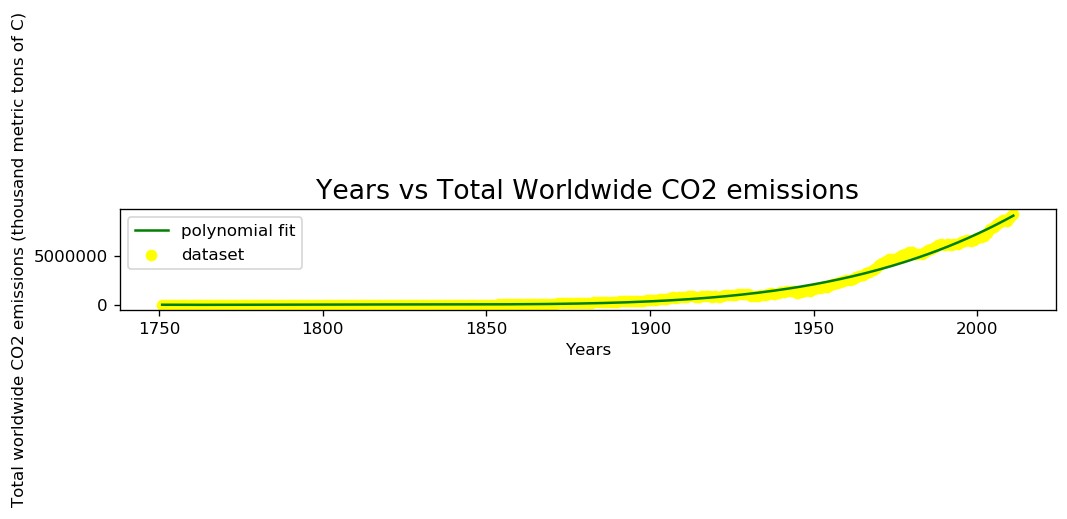

In [47]:
#attempting poly fitting degree 4
msk = np.random.rand(len(df5)) < 0.8
x_train, y_train = np.array(x_data[msk]).reshape(-1,1) , np.array(y_data[msk]).reshape(-1,1)
x_test, y_test = np.array(x_data[~msk]).reshape(-1,1) , np.array(y_data[~msk]).reshape(-1,1)
poly = PolynomialFeatures(degree=4)
train_x_poly = poly.fit_transform(x_train)
clf = linear_model.LinearRegression()
train_y_ = clf.fit(train_x_poly, y_train)
print(start + "Polynomial Approx".upper() + end)
print("Equation")
display(Math(r'\hat y = %.4f + %.4f \cdot x+ %.4f x^{2}+%.4f x^{3} + %.4f x^{4}' % (clf.intercept_[0],clf.coef_[0][1],clf.coef_[0][2],clf.coef_[0][3],clf.coef_[0][4])))
plt.scatter(x_data,y_data, color='yellow', label= 'dataset')
plt.plot(x_data, clf.intercept_[0]+ clf.coef_[0][1]*x_data+ clf.coef_[0][2]*np.power(x_data, 2) + clf.coef_[0][3]*np.power(x_data, 3) +clf.coef_[0][4]*np.power(x_data, 4), '-g', label = 'polynomial fit' )
test_x_poly = poly.fit_transform(x_test)
test_y_hat = clf.predict(test_x_poly)
table = [["Mean absolute error:",np.mean(np.absolute(test_y_hat - y_test))],
         ["Mean Squared Error (MSE):",mean_squared_error(y_test,test_y_hat)],
         ["Root Mean Squared Error (RMSE):",sqrt(mean_squared_error(y_test,test_y_hat))],
         ["R2-score:",r2_score(test_y_hat , y_test)]]
display(HTML(tabulate.tabulate(table, headers=["Evaluation","Value"],tablefmt='html',numalign="left",stralign="left",floatfmt=".4f")))
table = [["2011dataset (Year = 2011):",9.2148e+06],
         ["Polynomial fit prediction:",clf.intercept_[0]+ clf.coef_[0][1]*2011+ clf.coef_[0][2]*np.power(2011, 2) + clf.coef_[0][3]*np.power(2011, 3) +clf.coef_[0][4]*np.power(2011, 4)],
         ["Error %:",((clf.intercept_[0]+ clf.coef_[0][1]*2011+ clf.coef_[0][2]*np.power(2011, 2) + clf.coef_[0][3]*np.power(2011, 3) +clf.coef_[0][4]*np.power(2011, 4)-9.2148e+06)/9.2148e+06)*100]]
display(HTML(tabulate.tabulate(table, headers=["Comparison to ground truth","Value"],tablefmt='html',numalign="left",stralign="left",floatfmt=".4f")))
plt.title('Years vs Total Worldwide CO2 emissions', fontsize=16)
plt.xlabel('Years', fontsize=10)
plt.ylabel('Total worldwide CO2 emissions (thousand metric tons of C)', fontsize=10)
plt.tight_layout()
plt.legend()

LOGISTIC APPROX
Equation


<IPython.core.display.Math object>

Coefficients beta_1 = 92.157965, beta_2 = 0.983634


Evaluation,Value
Mean absolute error:,0.0127
Mean Squared Error (MSE):,0.0004
Root Mean Squared Error (RMSE):,0.0202
R2-score:,0.9762


Comparison to ground truth,Value
2011dataset (Year = 2011):,9214800.0000
Polynomial fit prediction:,7545156.2969
Error %:,-18.1192


10148129.099973


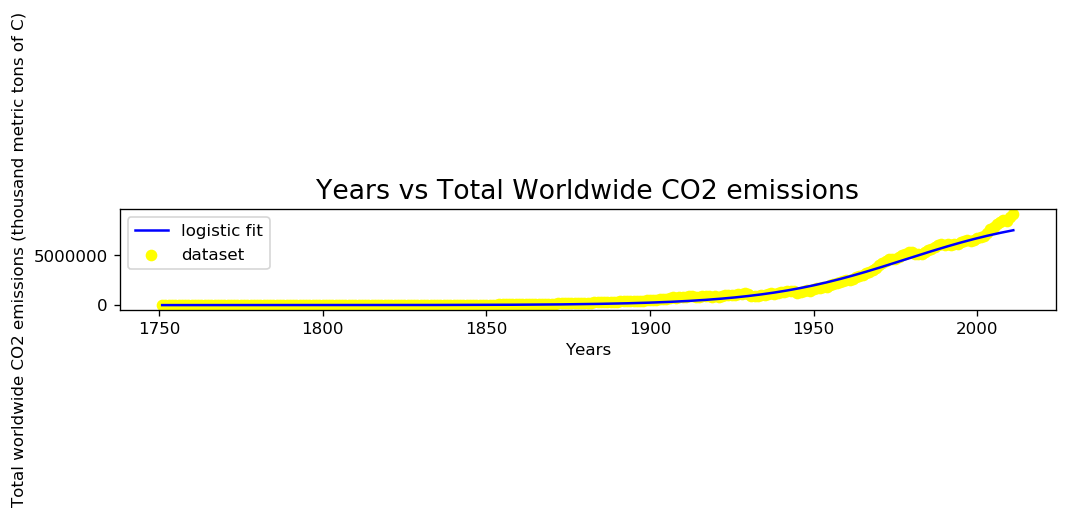

In [49]:

#attempting logistic function
xdata1 = x_data/max(x_data)
ydata1 = y_data/max(y_data)
def sigmoid(x, Beta_1, Beta_2):
     y = 1 / (1 + np.exp(-Beta_1*(x-Beta_2)))
     return y
plt.scatter(x_data,y_data, color='yellow', label= 'dataset')
#print the final parameters
msk = np.random.rand(len(df5)) < 0.8
x_train, y_train = xdata1[msk] , ydata1[msk]
x_test, y_test = xdata1[~msk] , ydata1[~msk]
popt, pcov = curve_fit(sigmoid, x_train, y_train)
popt, pcov = curve_fit(sigmoid, x_test, y_test)
test_y_hat = sigmoid(x_test,*popt)
print(start + "Logistic Approx".upper()+ end)
print("Equation")
display(Math(r'\hat y = 1/(1+e^{-%.4f \cdot (x-%.4f)}) ' % (popt[0],popt[1])))
print("Coefficients beta_1 = %f, beta_2 = %f" % (popt[0], popt[1]))
table = [["Mean absolute error:",np.mean(np.absolute(test_y_hat - y_test))],
         ["Mean Squared Error (MSE):",mean_squared_error(y_test,test_y_hat)],
         ["Root Mean Squared Error (RMSE):",sqrt(mean_squared_error(y_test,test_y_hat))],
         ["R2-score:",r2_score(test_y_hat , y_test)]]
display(HTML(tabulate.tabulate(table, headers=["Evaluation","Value"],tablefmt='html',numalign="left",stralign="left",floatfmt=".4f")))
table = [["2011dataset (Year = 2011):",9.2148e+06],
         ["Polynomial fit prediction:",(sigmoid(2011/max(x_data),*popt))*(max(y_data))],
         ["Error %:",(((sigmoid(2011/max(x_data),*popt))*(max(y_data))-9.2148e+06)/9.2148e+06)*100]]
display(HTML(tabulate.tabulate(table, headers=["Comparison to ground truth","Value"],tablefmt='html',numalign="left",stralign="left",floatfmt=".4f")))
#9.2148e+06/7828881.4449 * 8621836.568481168 = our 2030 emissions. linear approx from sigmoid
print(10148129.099973)
y = sigmoid(xdata1, *popt)
plt.plot(xdata1*max(x_data), y*max(y_data), 'blue', label="logistic fit")
plt.title('Years vs Total Worldwide CO2 emissions', fontsize=16)
plt.xlabel('Years', fontsize=10)
plt.ylabel('Total worldwide CO2 emissions (thousand metric tons of C)', fontsize=10)
plt.tight_layout()
plt.legend()

23763.02591465478 -43274940.53453544


Evaluation,Value
Mean absolute error:,1069792.5345
Mean Squared Error (MSE):,1512587098711.1274
Root Mean Squared Error (RMSE):,1229872.7978
R2-score:,0.5156


Comparison to ground truth,Value
2011dataset (Year = 2011):,9214800.0000
Linear fit prediction:,4512504.5798
Error %:,-51.0298


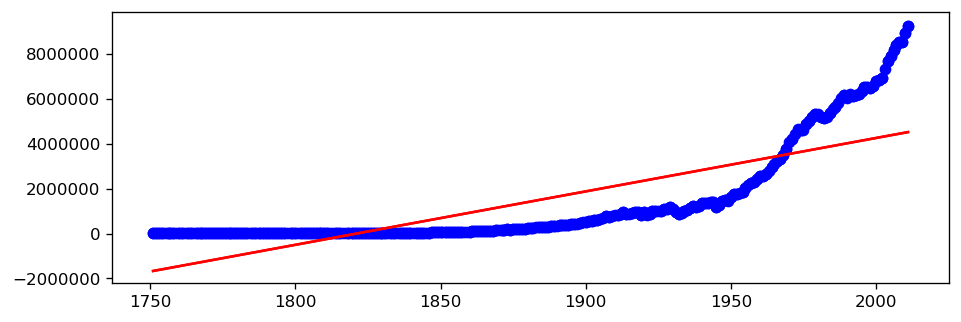

In [50]:
#Using Naive Regression Model on the data
#Create test and train dataset
msk = np.random.rand(len(df5)) < 0.8
train = df5[msk]
test = df5[~msk]
#train dataset 
train = train.rename(columns={"Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)": "TotalCO2"})
plt.scatter(train["Year"], train["TotalCO2"],  color='blue')
years = df5["Year"]
startYear = years[0]
plotYears = []
for x in years:
    plotYears.append(x-startYear)
df5["PlotYears"] = plotYears
#Obtain coefficients and intercept
regr = linear_model.LinearRegression()
x = np.asanyarray(train[["Year"]])
y = np.asanyarray(train[["TotalCO2"]])
regr.fit (x, y)
#Plot the training dataset
plt.scatter(train.Year, train.TotalCO2,  color='blue')
plt.plot(x, regr.coef_[0][0]*x + regr.intercept_[0], '-r')
test = test.rename(columns={"Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)":"TotalCO2"})
#Plot the test dataset
test_x = np.asanyarray(test[["Year"]])
test_y = np.asanyarray(test[["TotalCO2"]])
test_y_hat = regr.predict(test_x)
#Plot test data
plt.scatter(test.Year, test.TotalCO2,  color='blue')
plt.plot(x, regr.coef_[0][0]*x + regr.intercept_[0], '-r')
print(regr.coef_[0][0],regr.intercept_[0])
table = [["Mean absolute error:",np.mean(np.absolute(test_y_hat - test_y))],
         ["Mean Squared Error (MSE):",mean_squared_error(test_y,test_y_hat)],
         ["Root Mean Squared Error (RMSE):",sqrt(mean_squared_error(test_y,test_y_hat))],
         ["R2-score:",r2_score(test_y_hat , test_y)]]
display(HTML(tabulate.tabulate(table, headers=["Evaluation","Value"],tablefmt='html',numalign="left",stralign="left",floatfmt=".4f")))
table = [["2011dataset (Year = 2011):",9.2148e+06],
         ["Linear fit prediction:",regr.intercept_[0]+ regr.coef_[0][0]*2011],
         ["Error %:",(((regr.intercept_[0]+ regr.coef_[0][0]*2011)-9.2148e+06)/9.2148e+06)*100]]
display(HTML(tabulate.tabulate(table, headers=["Comparison to ground truth","Value"],tablefmt='html',numalign="left",stralign="left",floatfmt=".4f")))

In [51]:
#Comparison of predicted 2030 data
table = [["Linear fit prediction:",regr.coef_[0][0]*2030 + regr.intercept_[0]],
         ["Exponential fit prediction:",np.exp(regr.predict(np.array(2030).reshape(-1,1)))],
         ["Polynomial fit prediction:",clf.intercept_[0]+ clf.coef_[0][1]*2030+ clf.coef_[0][2]*np.power(2030, 2) + clf.coef_[0][3]*np.power(2030, 3) +clf.coef_[0][4]*np.power(2030, 4)],
         ["Logistic fit prediction:",((sigmoid(2030/max(x_data),*popt))*(max(y_data)))]]
display(HTML(tabulate.tabulate(table, headers=["Prediction 2030","Value"],tablefmt='html',numalign="left",stralign="left",floatfmt=".4f")))
#9.2148e+06/7828881.4449 * 8621836.568481168 = our 2030 emissions. linear extrapolation from sigmoid at 2011
print(10148129.099973)

Prediction 2030,Value
Linear fit prediction:,4964002.0722
Exponential fit prediction:,inf
Polynomial fit prediction:,252954308820.7151
Logistic fit prediction:,8433498.5704


10148129.099973


Evaluation,Value
Mean absolute error:,121903.3514
Mean Squared Error (MSE):,19738242714.8969
Root Mean Squared Error (RMSE):,140492.8565
R2-score:,0.9926


Linear fit prediction 2030: 10666733.219401568


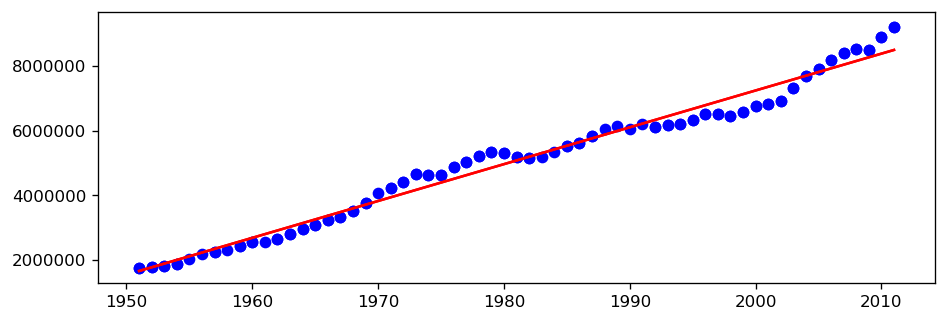

In [52]:
#Linear Fit Regression on data from 1950 to present
dat = df5[(df5["Year"] > 1950.0)].index.tolist()
xdat = df5.loc[dat,"Year"]
ydat = df5.loc[dat,"Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)"]
#Create test and train dataset
msk = np.random.rand(len(xdat)) < 0.8
xtrain = xdat[msk]
ytrain = ydat[msk]
xtest = xdat[~msk]
ytest = ydat[~msk]
#train dataset 
plt.scatter(xtrain, ytrain,  color='blue')
#Obtain coefficients and intercept
regr = linear_model.LinearRegression()
x = np.asanyarray(xtrain).reshape(-1,1)
y = np.asanyarray(ytrain).reshape(-1,1)
regr.fit (x, y)
#Plot the training dataset
plt.scatter(xtrain, ytrain,  color='blue')
plt.plot(x, regr.coef_[0][0]*x + regr.intercept_[0], '-r')
#Plot the test dataset
test_x = np.asanyarray(xtest).reshape(-1,1)
test_y = np.asanyarray(ytest).reshape(-1,1)
test_y_hat = regr.predict(test_x)
#Plot test data
plt.scatter(xtest, ytest,  color='blue')
plt.plot(xdat, regr.coef_[0][0]*xdat + regr.intercept_[0], '-r')
table = [["Mean absolute error:",np.mean(np.absolute(test_y_hat - test_y))],
         ["Mean Squared Error (MSE):",mean_squared_error(test_y,test_y_hat)],
         ["Root Mean Squared Error (RMSE):",sqrt(mean_squared_error(test_y,test_y_hat))],
         ["R2-score:",r2_score(test_y_hat , test_y)]]
display(HTML(tabulate.tabulate(table, headers=["Evaluation","Value"],tablefmt='html',numalign="left",stralign="left",floatfmt=".4f")))
print("Linear fit prediction 2030:",regr.coef_[0][0]*2030 + regr.intercept_[0])

ADF Statistic: -1.179632
p-value: 0.682296


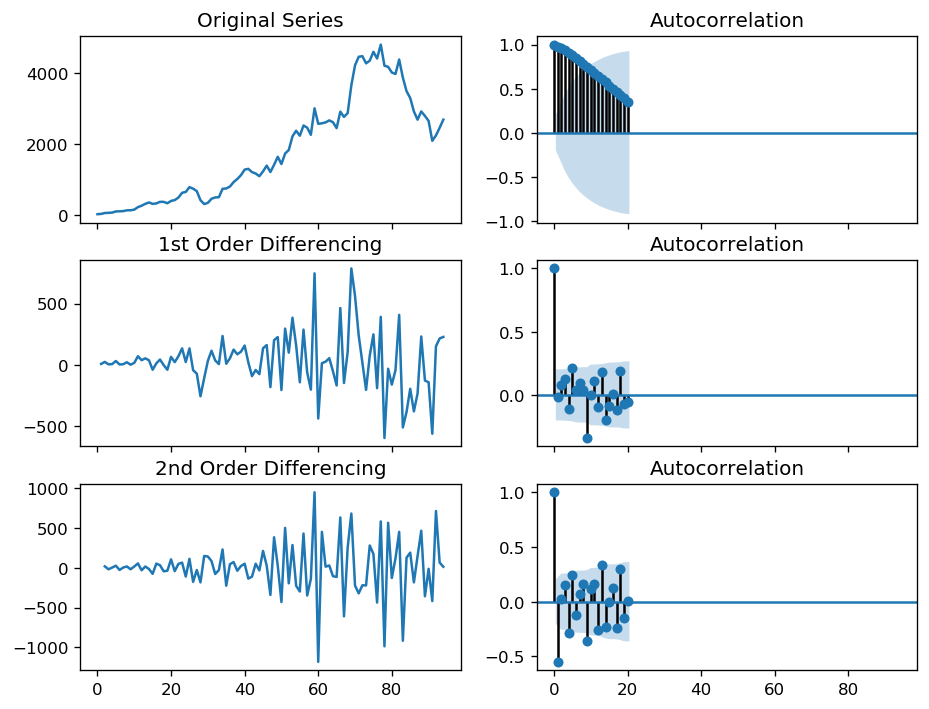

2
1
1


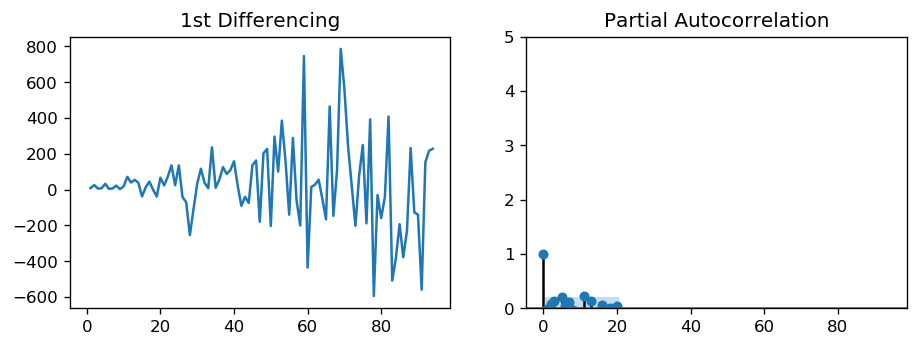

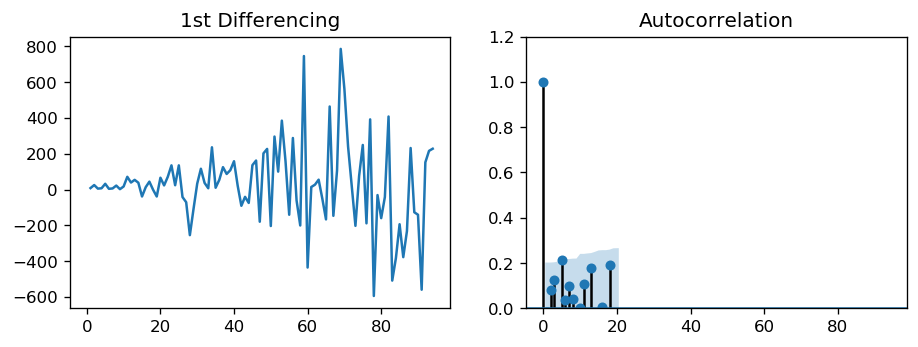

                                                                 ARIMA Model Results                                                                  
Dep. Variable:     D2.Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)   No. Observations:                   93
Model:                                                                                         ARIMA(1, 2, 2)   Log Likelihood                -638.830
Method:                                                                                               css-mle   S.D. of innovations            227.143
Date:                                                                                        Sun, 08 Dec 2019   AIC                           1287.660
Time:                                                                                                15:33:38   BIC                           1300.323
Sample:                                                                                       

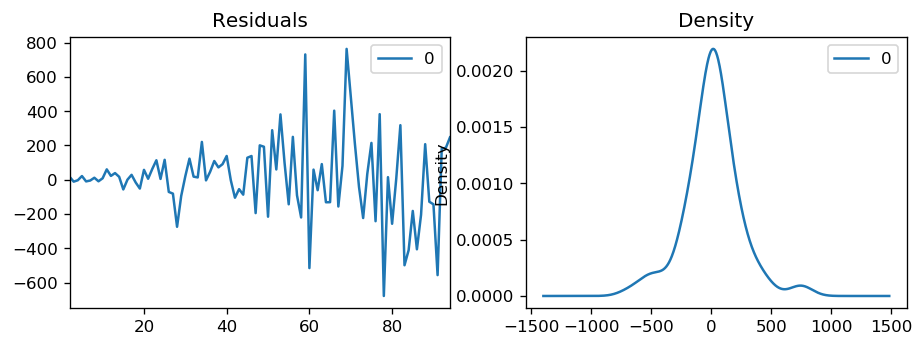

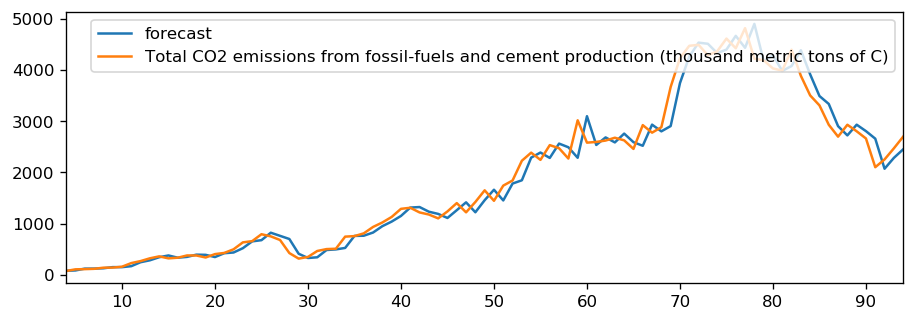

                                                                 ARIMA Model Results                                                                 
Dep. Variable:     D.Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)   No. Observations:                   70
Model:                                                                                        ARIMA(2, 1, 1)   Log Likelihood                -465.972
Method:                                                                                              css-mle   S.D. of innovations            187.977
Date:                                                                                       Sun, 08 Dec 2019   AIC                            941.945
Time:                                                                                               15:33:40   BIC                            953.187
Sample:                                                                                             

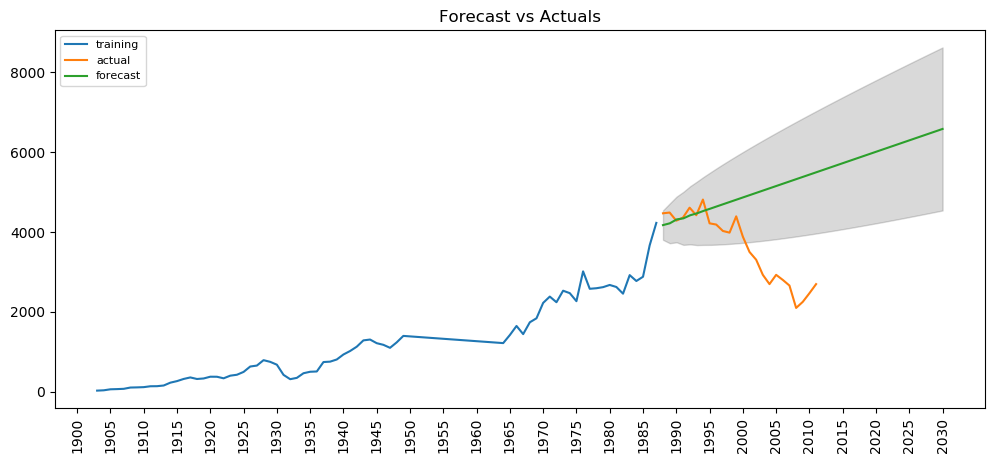

In [62]:
#Performed ARIMA on US Data Only
#For use in Spyder data read
dataset = pd.read_csv('nation.1751_2011.csv')
#replace all '.' with 0 in the dataset, drop 'Per capita' column, aggregate values from bunker fuels to total
dataset = dataset.drop('Per capita CO2 emissions (metric tons of carbon)', axis=1)
df = dataset.drop([0, 1], axis=0).replace('.',0)
#all numerical columns transformed to floats
for i in range(1,len(df.columns)):
    df[df.columns[i]] = df[df.columns[i]].astype('float64')
df['Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)'] = df['Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)'] + df['Emissions from bunker fuels (not included in the totals)']
df = df.drop('Emissions from bunker fuels (not included in the totals)', axis=1)
#Kuwait oil fires are aggregated to Kuwait at year 1991
data1= df.loc[8222] + df.loc[8243]
data1[0] = 'KUWAIT'
data1[1] = data1[1] - 1991
df.loc[8222] = data1
df = df.drop(index = 8243)
#grouping by Nation name
grouped = df.groupby(['Nation'])
#storing each dataframe in a dict for easy access to each country's data, df2 is the first cleaning revision
df2 = {}
for name,group in grouped:
    df2[name] = pd.DataFrame(group)
# remove all columns that contain 0 in all rows. update df2, the second cleaning revision
for key,value in df2.items():
    df2[key] = df2[key].loc[:, ~(df2[key] == 0).all()]
df6 = df2['UNITED STATES OF AMERICA']
df6 = value.drop(['Nation','Emissions from solid fuel consumption','Emissions from liquid fuel consumption','Emissions from gas fuel consumption','Emissions from cement production','Emissions from gas flaring'], axis=1)
df6.reset_index(drop=True,inplace=True)
x_data = df6["Year"]
y_data = df6["Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)"]
#ad fuller test to verify stationary behavior
result = adfuller(y_data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#p is the order of the AR term
#q is the order of the MA term
#d is the number of differencing required to make the time series stationary
# conda install -c saravji pmdarima
# finding d the number of differencing required
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(y_data); axes[0, 0].set_title('Original Series')
plot_acf(y_data, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(y_data.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(y_data.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(y_data.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(y_data.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

#Estimate correct ARIMA hyperparameters

## Adf Test
print(ndiffs(y_data, test='adf'))

# KPSS test
print(ndiffs(y_data, test='kpss'))

# PP test:
print(ndiffs(y_data, test='pp'))
# PACF plot of 1st differenced series p
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(y_data.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(y_data.diff().dropna(), ax=axes[1])

plt.show()
#ACF plot for the number of MA terms q


plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(y_data.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(y_data.diff().dropna(), ax=axes[1])

plt.show()

#ARIMA model on whole dataset


# 1,1,2 ARIMA Model
model = ARIMA(y_data, order=(1,2,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

model_fit.plot_predict(dynamic=False)
plt.show()

#Find Forecast using ARIMA

#Create test and train dataset
train = y_data[:71]
test = y_data[71:]
xtrain = x_data[:71]
xtest = x_data[71:]
# Build Model
model = ARIMA(train, order=(2, 1, 1))
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(42, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index =np.linspace(71,113,num=42))
lower_series = pd.Series(conf[:, 0], index=np.linspace(71,113,num=42))
upper_series = pd.Series(conf[:, 1], index=np.linspace(71,113,num=42))
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(xtrain,train, label='training')
plt.plot(xtest,test, label='actual')
plt.plot(np.linspace(1988,2030,num=42),fc_series, label='forecast')
plt.fill_between(np.linspace(1988,2030,num=42), lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.xticks(range(1900, 2035,5),rotation=90)
plt.legend(loc='upper left', fontsize=8)
plt.show()

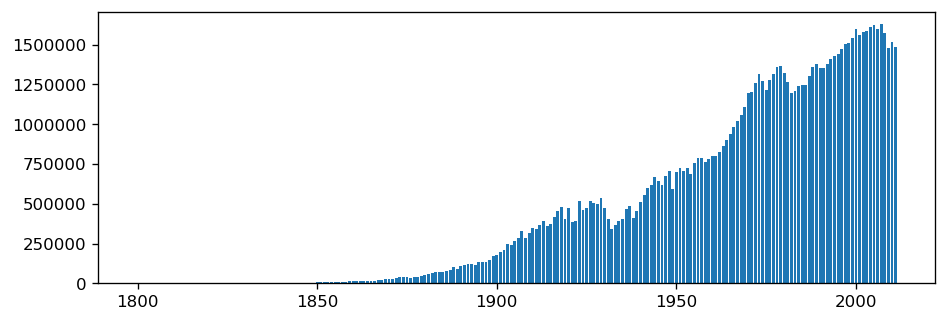

ADF Statistic: -0.461545
p-value: 0.899305


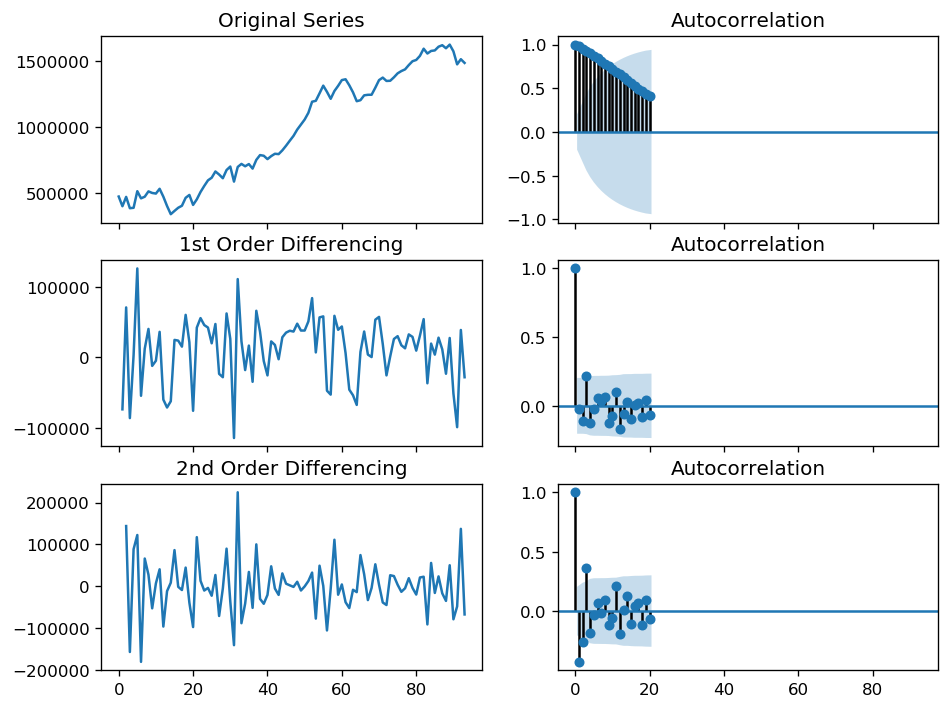

1
1
1


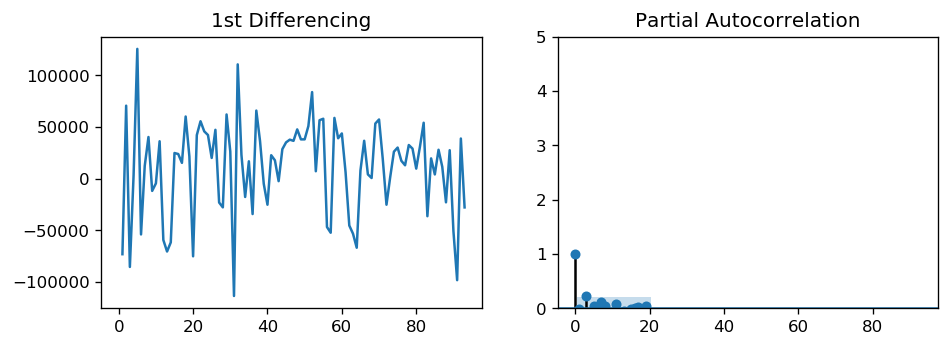

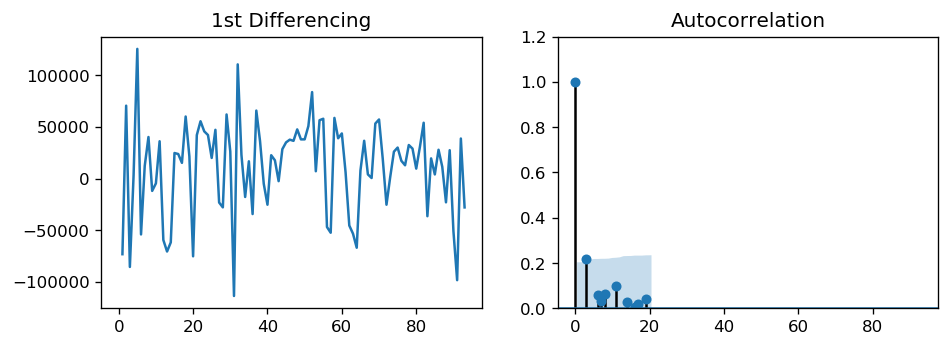

                                                                 ARIMA Model Results                                                                 
Dep. Variable:     D.Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)   No. Observations:                   93
Model:                                                                                        ARIMA(2, 1, 1)   Log Likelihood               -1123.889
Method:                                                                                              css-mle   S.D. of innovations          42760.328
Date:                                                                                       Sun, 08 Dec 2019   AIC                           2257.778
Time:                                                                                               14:41:37   BIC                           2270.441
Sample:                                                                                             

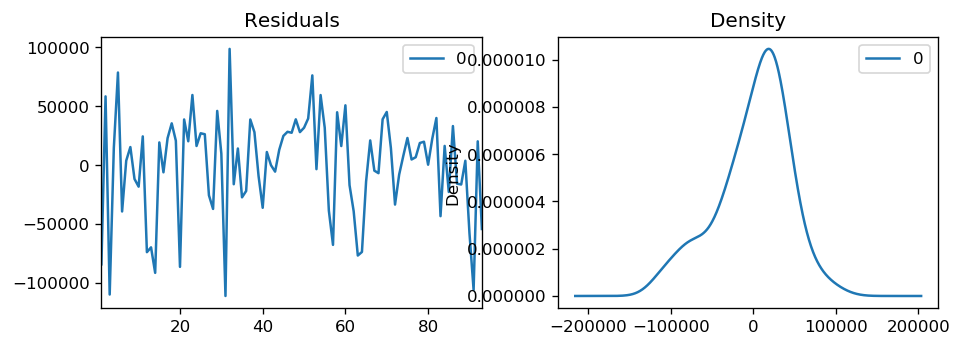

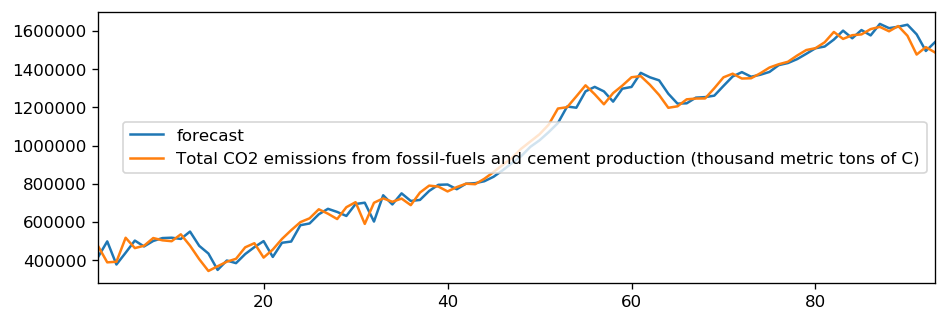

94
                                                                 ARIMA Model Results                                                                 
Dep. Variable:     D.Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)   No. Observations:                   70
Model:                                                                                        ARIMA(2, 1, 1)   Log Likelihood                -849.787
Method:                                                                                              css-mle   S.D. of innovations          45085.610
Date:                                                                                       Sun, 08 Dec 2019   AIC                           1709.574
Time:                                                                                               14:41:39   BIC                           1720.817
Sample:                                                                                          

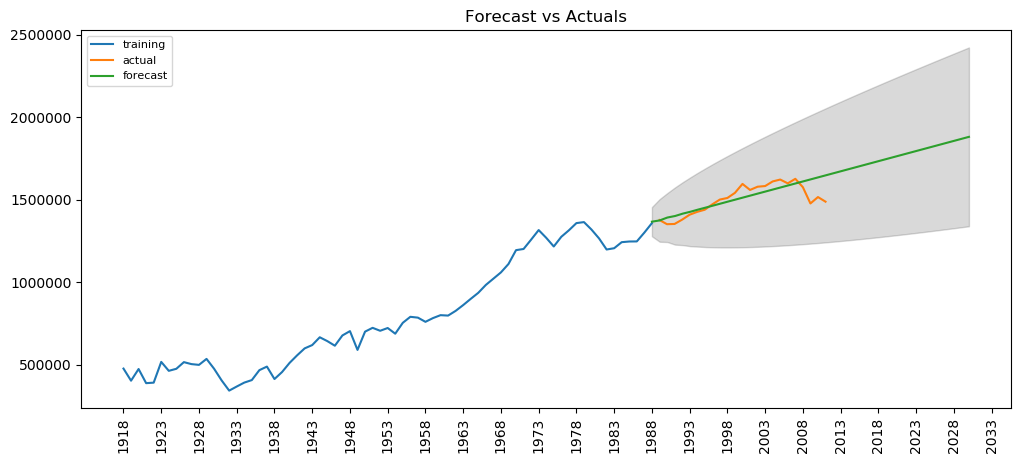

In [30]:
#Chopping off values from histogram distribution starting at 1918 due to it having better p<0.05
# remove all columns that contain 0 in all rows. update df2, the second cleaning revision
df6 = df2['UNITED STATES OF AMERICA']
df6 = df6.drop(['Nation','Emissions from solid fuel consumption','Emissions from liquid fuel consumption','Emissions from gas fuel consumption','Emissions from cement production','Emissions from gas flaring'], axis=1)
df6.reset_index(drop=True,inplace=True)
x_data = df6["Year"]
y_data = df6["Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)"]
plt.bar(x=x_data,height=y_data)
plt.show()
dat = df6[(df6["Year"] > 1917)].index.tolist()
xdat = df6.loc[dat,"Year"]
ydat = df6.loc[dat,"Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)"]
ydat.reset_index(drop=True, inplace=True)

#Arima
#p value has to be less than 0.05 to prove stationarity
result = adfuller(ydat)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#p is the order of the AR term
#q is the order of the MA term
#d is the number of differencing required to make the time series stationary
# conda install -c saravji pmdarima
# finding d the number of differencing required

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(ydat); axes[0, 0].set_title('Original Series')
plot_acf(ydat, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(ydat.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(ydat.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(ydat.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(ydat.diff().diff().dropna(), ax=axes[2, 1])

plt.show()
#!pip install pmdarima

## Adf Test
print(ndiffs(ydat, test='adf'))

# KPSS test
print(ndiffs(ydat, test='kpss'))

# PP test:
print(ndiffs(ydat, test='pp'))
# PACF plot of 1st differenced series p
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(ydat.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(ydat.diff().dropna(), ax=axes[1])

plt.show()
#ACF plot for the number of MA terms q


plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(ydat.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(ydat.diff().dropna(), ax=axes[1])

plt.show()


# 2,1,1 ARIMA Model of whole dataset
model = ARIMA(ydat, order=(2,1,1))
model_fit = model.fit(disp=-1)
print(model_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

model_fit.plot_predict(dynamic=False)
plt.show()


#Create test and train dataset
train = ydat[:71]
test = ydat[71:]
xtrain = xdat[:71]
xtest = xdat[71:]
# Build Model
model = ARIMA(train, order=(2, 1, 1))
fitted = model.fit(disp=-1)  
print(fitted.summary())
# Forecast
fc, se, conf = fitted.forecast(42, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index =np.linspace(71,113,num=42))
lower_series = pd.Series(conf[:, 0], index=np.linspace(71,113,num=42))
upper_series = pd.Series(conf[:, 1], index=np.linspace(71,113,num=42))
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(xtrain,train, label='training')
plt.plot(xtest,test, label='actual')
plt.plot(np.linspace(1988,2030,num=42),fc_series, label='forecast')
plt.fill_between(np.linspace(1988,2030,num=42), lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.xticks(range(1918, 2035,5),rotation=90)
plt.legend(loc='upper left', fontsize=8)
plt.show()

ARIMA not successfull on US data because data still has alot of variance in its mean. Even after removing some of the data to reduce the mean, the ARIMA model was not able to accurately predict values within p<0.05

In [27]:
#ARIMA models on chopped data starting from either 1910 to 1920 to show the lowest p<0.05
for i in range(1910,1920):
  dat = df6[(df6["Year"] > i)].index.tolist()
  xdat = df6.loc[dat,"Year"]
  ydat = df6.loc[dat,"Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)"]
  ydat.reset_index(drop=True, inplace=True)
  model = ARIMA(ydat, order=(2,1,1))
  model_fit = model.fit(disp=-1)
  print(i,model_fit.summary())
  

1910                                                                  ARIMA Model Results                                                                 
Dep. Variable:     D.Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)   No. Observations:                  100
Model:                                                                                        ARIMA(2, 1, 1)   Log Likelihood               -1205.972
Method:                                                                                              css-mle   S.D. of innovations          41689.656
Date:                                                                                       Sun, 08 Dec 2019   AIC                           2421.944
Time:                                                                                               14:38:25   BIC                           2434.970
Sample:                                                                                        

1913                                                                  ARIMA Model Results                                                                 
Dep. Variable:     D.Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)   No. Observations:                   97
Model:                                                                                        ARIMA(2, 1, 1)   Log Likelihood               -1170.973
Method:                                                                                              css-mle   S.D. of innovations          42196.430
Date:                                                                                       Sun, 08 Dec 2019   AIC                           2351.946
Time:                                                                                               14:38:26   BIC                           2364.819
Sample:                                                                                        

1916                                                                  ARIMA Model Results                                                                 
Dep. Variable:     D.Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)   No. Observations:                   94
Model:                                                                                        ARIMA(2, 1, 1)   Log Likelihood               -1135.556
Method:                                                                                              css-mle   S.D. of innovations          42559.859
Date:                                                                                       Sun, 08 Dec 2019   AIC                           2281.111
Time:                                                                                               14:38:27   BIC                           2293.828
Sample:                                                                                        

1919                                                                  ARIMA Model Results                                                                 
Dep. Variable:     D.Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)   No. Observations:                   91
Model:                                                                                        ARIMA(2, 1, 1)   Log Likelihood               -1098.326
Method:                                                                                              css-mle   S.D. of innovations          42159.604
Date:                                                                                       Sun, 08 Dec 2019   AIC                           2206.651
Time:                                                                                               14:38:28   BIC                           2219.205
Sample:                                                                                        

Attempted running ARIMA on US data from lower x limit of 1910-1920 to observe if p<0.05 was achieved

In [60]:
#Comparison to Ground Truth and R2 Score.
table = [["2011dataset (Year = 2011):",9.2148e+06],
         ["Exponential fit prediction:",np.exp(regr.predict(np.array(2011).reshape(-1,1)))],
         ["Polynomial fit prediction:",clf.intercept_[0]+ clf.coef_[0][1]*2011+ clf.coef_[0][2]*np.power(2011, 2) + clf.coef_[0][3]*np.power(2011, 3) +clf.coef_[0][4]*np.power(2011, 4)],
         ["Logistic fit prediction:",((sigmoid(2011/max(x_data),*popt))*(max(y_data)))],
         ["Tableau Forecast Value (Year = 2011):",8912492],
         ["Error Exponential %:",((np.exp(regr.predict(np.array(2011).reshape(-1,1)))-9.2148e+06)/9.2148e+06)*100],
         ["Error Polynomial %:",(((clf.intercept_[0]+ clf.coef_[0][1]*2011+ clf.coef_[0][2]*np.power(2011, 2) + clf.coef_[0][3]*np.power(2011, 3) +clf.coef_[0][4]*np.power(2011, 4))-9.2148e+06)/9.2148e+06)*100],
         ["Error Logistic %:",(((((sigmoid(2011/max(x_data),*popt))*(max(y_data))))-9.2148e+06)/9.2148e+06)*100],
         ["Error Logistic Tableau %:",((8912492-9.2148e+06)/9.2148e+06)*100],
         ["R2-score Exponential:",r2_score(np.exp(regr.predict(np.array(xdata).reshape(-1,1))) , ydata)],
         ["R2-score Polynomial:",r2_score(clf.intercept_[0]+ clf.coef_[0][1]*xdata+ clf.coef_[0][2]*np.power(xdata, 2) + clf.coef_[0][3]*np.power(xdata, 3) +clf.coef_[0][4]*np.power(xdata, 4) , ydata)],
         ["R2-score Logistic:",r2_score(((sigmoid(xdata/max(x_data),*popt))*(max(y_data))), ydata)],
         ["R2-score Logistic Tableau:",r2_score(4.33019e+07*np.log(xdata)+-3.25048e+08, ydata)]]
display(HTML(tabulate.tabulate(table, headers=["Comparison to ground truth on 2011 and R2 Score","Value"],tablefmt='html',numalign="left",stralign="left",floatfmt=".4f")))

Comparison to ground truth on 2011 and R2 Score,Value
2011dataset (Year = 2011):,9214800.0000
Exponential fit prediction:,15493460.0256
Polynomial fit prediction:,256463799222.2894
Logistic fit prediction:,7545156.2969
Tableau Forecast Value (Year = 2011):,8912492.0000
Error Exponential %:,68.1367
Error Polynomial %:,2783072.7137
Error Logistic %:,-18.1192
Error Logistic Tableau %:,-3.2807
R2-score Exponential:,-0.2814


In [64]:
#For use in Spyder data read
dataset = pd.read_csv('nation.1751_2011.csv')
#replace all '.' with 0 in the dataset, drop 'Per capita' column, aggregate values from bunker fuels to total
dataset = dataset.drop('Per capita CO2 emissions (metric tons of carbon)', axis=1)
df = dataset.drop([0, 1], axis=0).replace('.',0)
#all numerical columns transformed to floats
for i in range(1,len(df.columns)):
    df[df.columns[i]] = df[df.columns[i]].astype('float64')
df['Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)'] = df['Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)'] + df['Emissions from bunker fuels (not included in the totals)']
df = df.drop('Emissions from bunker fuels (not included in the totals)', axis=1)
#Kuwait oil fires are aggregated to Kuwait at year 1991
data1= df.loc[8222] + df.loc[8243]
data1[0] = 'KUWAIT'
data1[1] = data1[1] - 1991
df.loc[8222] = data1
df = df.drop(index = 8243)
#grouping by Nation name
grouped = df.groupby(['Nation'])
#storing each dataframe in a dict for easy access to each country's data, df2 is the first cleaning revision
df2 = {}
for name,group in grouped:
    df2[name] = pd.DataFrame(group)
# remove all columns that contain 0 in all rows. update df2, the second cleaning revision
for key,value in df2.items():
    df2[key] = df2[key].loc[:, ~(df2[key] == 0).all()]
#summary of distribution for each country
dfsummary = {}
for key,value in df2.items():
    dfsummary[key] = pd.DataFrame(value).describe(include='all')
#Correlation matrix of each country data among all columns. Storing the counts of each correlation for each country
corrcomp = []
corr2 = {}
for key,value in df2.items():
    df3 = df2[key]
    df3 = df3.rename(columns={'Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)':2,'Emissions from solid fuel consumption':3,'Emissions from liquid fuel consumption':4,'Emissions from gas fuel consumption':5,'Emissions from cement production':6, 'Emissions from gas flaring':7,'Per capita CO2 emissions (metric tons of carbon)':8,'Emissions from bunker fuels (not included in the totals)':9})
    corr = df3[df3.columns[1:10]].corr()
    mask = np.tril(np.ones_like(corr, dtype=np.bool), k=-1)
    corr1 = corr.where(mask)
    countrealint = np.count_nonzero(~np.isnan(corr1))
    corrcomp.append({key:countrealint})
    corr2[key] = pd.DataFrame(corr1)
#Creating lists of key,values out of the corrcomp list(dictionary)
all_keys = []
all_vals = []
for k, v in [(k, v) for x in corrcomp for (k, v) in x.items()]:
    all_keys.append(k)
    all_vals.append(v)
#Finding the country's measures that have no correlation
for j in range(0,37): j,[i for i, e in enumerate(all_vals) if e == j]
dropindex = [i for i, e in enumerate(all_vals) if e == 0]
#Aggregated country values 'Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)' per year in a dictionary, then converted to dataframe for easy plotting and use with ML Regression
df5 = {}
groupd = df.groupby(['Year'])
for year,group in groupd:
    df5[year] = pd.DataFrame(group)
for key, value in df5.items():
    df5[key] = value.drop(['Nation','Year','Emissions from solid fuel consumption','Emissions from liquid fuel consumption','Emissions from gas fuel consumption','Emissions from cement production','Emissions from gas flaring'], axis=1)
    df5[key] = sum(df5[key]['Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)'])
df5 =  pd.DataFrame(list(df5.items()), columns=['Year', 'Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)'])
#Prepare data for analysis
x_data = df5["Year"]
y_data = df5["Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)"]

TypeError: descriptor 'strftime' requires a 'datetime.date' object but received a 'int'

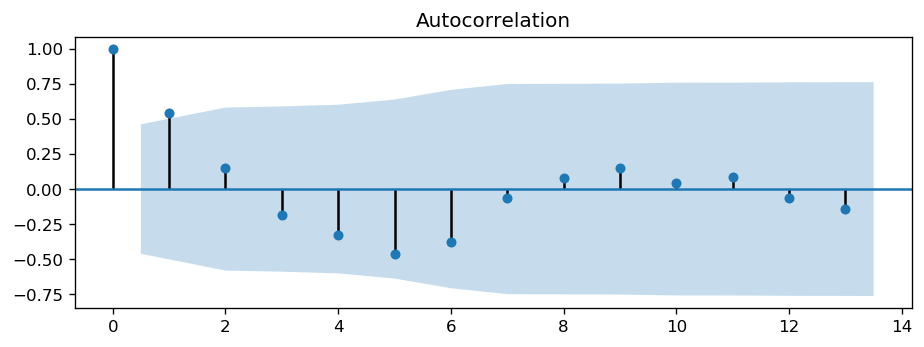

In [65]:
x_data = df5["Year"]
y_data = df5["Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)"]
x_data = x_data.astype(int)
df5["Year"] = x_data
df5 = df5.set_index("Year")
df6 = df5.loc[1980:2000]
plot_acf(df6.diff(3)[3:])
df7 = df6.diff(3)[3:]
x_data = df7.index
y_data = df7["Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)"]
k = []
for x in x_data:
    k.append(datetime.datetime.strptime(str(x),'%Y'))

k = []
for x in x_data:
    k.append(datetime.datetime.strftime(x,"%Y"))

x_data = k
y_data = df7["Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)"]
df7["Year_str"] = x_data

model = ARIMA(np.array(y_data), order=(3, 2, 0))
fitted = model.fit(disp=-1)
print(fitted.summary())

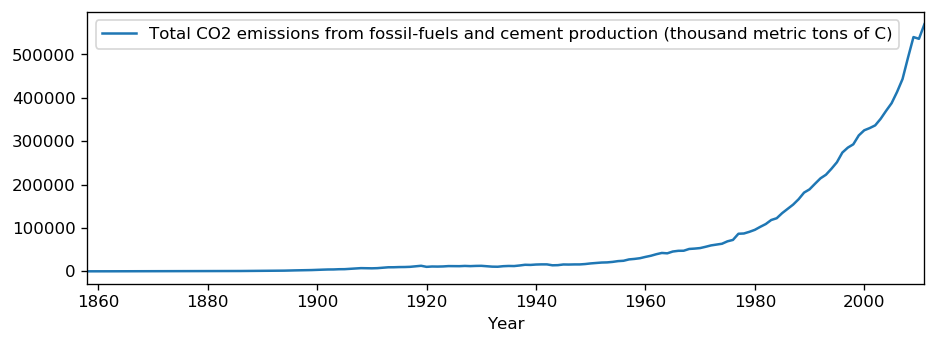

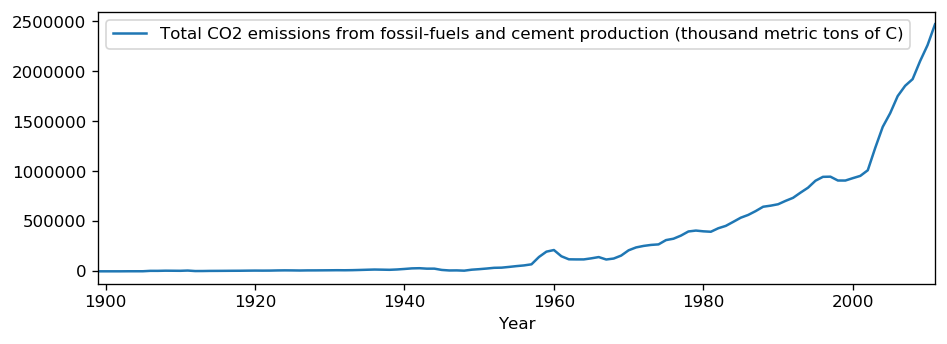

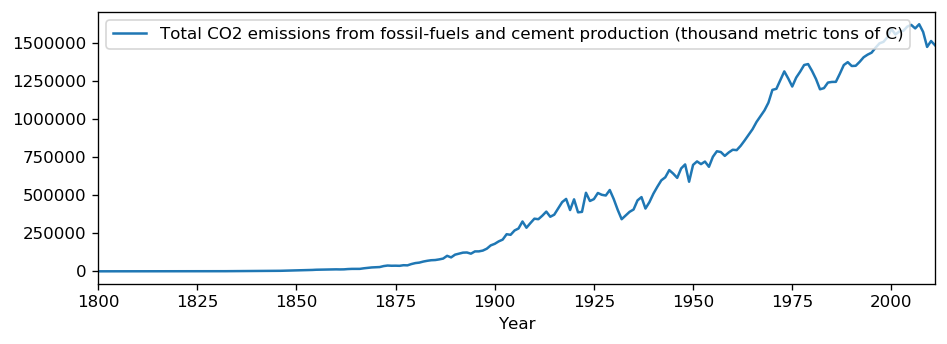

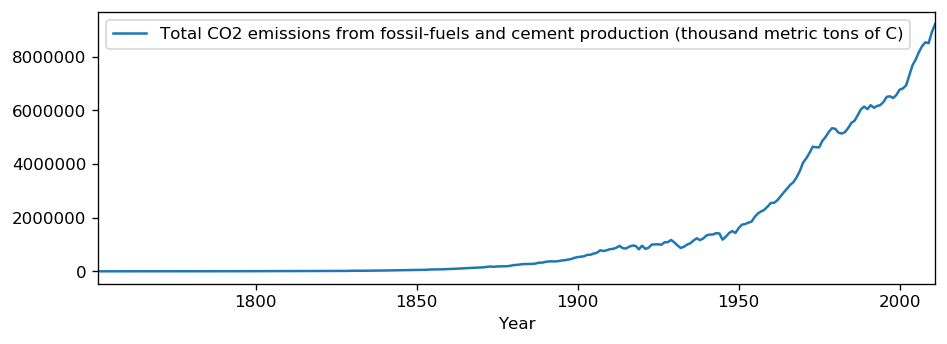

In [66]:
dfChina = df2["CHINA (MAINLAND)"]
dfChina = dfChina.set_index("Year")
dfChina = dfChina.drop(["Emissions from solid fuel consumption","Nation","Emissions from liquid fuel consumption","Emissions from gas fuel consumption","Emissions from cement production","Emissions from gas flaring"],axis=1)

dfIndia = df2["INDIA"]
dfIndia = dfIndia.set_index("Year")
dfIndia = dfIndia.drop(["Emissions from solid fuel consumption","Nation","Emissions from liquid fuel consumption","Emissions from gas fuel consumption","Emissions from cement production","Emissions from gas flaring"],axis=1)

dfTest1 = pd.DataFrame()
dfTest1 = df2["UNITED STATES OF AMERICA"]
dfTest1 = dfTest1.set_index("Year")
dfTest1 = dfTest1.drop(["Emissions from solid fuel consumption","Nation","Emissions from liquid fuel consumption","Emissions from gas fuel consumption","Emissions from cement production","Emissions from gas flaring"],axis=1)

dfIndia.plot()
dfChina.plot()
dfTest1.plot()
df5.plot()